In [1]:
import pandas as pd
import numpy as np

## 데이터 불러오기

In [4]:
selloutData = pd.read_csv("./dataset/kopo_decision_tree_all_new.csv")

## 1. 지역/상품/아이템별 146개 제품 추출

In [5]:
selloutData.columns

Index(['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM', 'YEARWEEK', 'YEAR',
       'WEEK', 'QTY', 'HOLIDAY', 'HCLUS', 'PROMOTION', 'PRO_PERCENT'],
      dtype='object')

In [6]:
groupKey = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "ITEM"]

In [7]:
groupData = selloutData.\
            groupby(groupKey)["YEARWEEK"].\
            agg(["size"]).reset_index()

In [10]:
groupData.rename(columns={"size":"KNOB"}, inplace=True)

In [ ]:
# selloutData와 join
mergedData = pd.merge(left=selloutData,
            right=groupData,
            on=groupKey,
            how='left')

In [16]:
maxknob = mergedData.KNOB.max()

In [19]:
refinedData = mergedData[mergedData.KNOB >= maxknob]

In [27]:
sortKey = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "YEARWEEK", "ITEM"]

In [28]:
sortedData = refinedData.sort_values(sortKey).reset_index(drop=True)

In [29]:
sortedData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB
0,A01,PG02,P03,ITEM043,201501,2015,1,87,Y,1,Y,0.197590,146
1,A01,PG02,P03,ITEM044,201501,2015,1,66,Y,1,Y,0.249246,146
2,A01,PG02,P03,ITEM051,201501,2015,1,21,Y,1,Y,0.267742,146
3,A01,PG02,P03,ITEM053,201501,2015,1,348,Y,1,Y,0.316722,146
4,A01,PG02,P03,ITEM054,201501,2015,1,33,Y,1,Y,0.267742,146


In [30]:
sortedData.YEARWEEK.min()

201501

In [31]:
sortedData.YEARWEEK.max()

201741

## 2. 그룹별로 나누어서 예측

In [33]:
# 2017년 1주차부터 미래예측한다고 가정해보자
stdYearweek = 201701

In [35]:
groupsData = sortedData.groupby(groupKey)

In [ ]:
# 0을 두개 만큼 반복시키는 로직 생성
list(np.repeat(0,20))

In [79]:
# 함수화 시키기
def dtPredict(onegroup) :

    # 하나의 그룹만 보고싶을때 => 그룹데이터의 0번째 그룹만 가져와보자
#     onegroup = groupsData.get_group(list(groupsData.groups)[2])

    eachgroup = onegroup.reset_index(drop=True)

    #### 1. feature(특성) 선별

    corrdf = eachgroup.corr()
    corrStd = 0.5
    #조건을 두개로 주는 멀티조건일때는 각각의 조건을 괄호로 감싸기
    features = list(corrdf[(abs(corrdf["QTY"]) >= corrStd) & (corrdf["QTY"] != 1)].index)
    
    featureslen = len(features)
    
    # fullDataSet을 하나 마련해두자
    testData_all = eachgroup[eachgroup.YEARWEEK >= stdYearweek]
    testDataSize = len(testData_all)
    
    # 만약, features가 없는 그룹이 존재할 경우 예측값을 0으로 산출하기 위해 조건을 건다
    if(featureslen == 0) :
        # 0을 testDataSize 만큼 반복시키는 로직 생성
        predict = list(np.repeat(0,testDataSize))
        testData_all["PREDICT"] = predict
        
    
    else :
        
        label = ["QTY"]

        #### 2. 데이터분리(훈련/테스트)

        trainingData_features = eachgroup[eachgroup.YEARWEEK < stdYearweek][features]
        traingData_label = eachgroup[eachgroup.YEARWEEK < stdYearweek][label]
        testData_features = eachgroup[eachgroup.YEARWEEK >= stdYearweek][features]
        testData_label = eachgroup[eachgroup.YEARWEEK >= stdYearweek][label]
       
        #### 3. 모델 선언

        from sklearn import tree

        # random_state : 난수를 발생시켜서 모델을 돌리는데, 
        # 어떠한 숫자로 고정을 시켜두면 다시 돌렸을 떄 동일한 결과를 나타내게 함으로써 재연이 가능하게 함
        model_method = tree.DecisionTreeRegressor(random_state=32)

        #### 4. 훈련(훈련데이터 특성/답지 활용)

        model = model_method.fit(trainingData_features, traingData_label)
        # y: 최종결과값이 나오는 결과값
        # x: 거기에 영향을 주는 features로 생각하면됨

        # => 훈련의 결과는 현재 model이 가지고 있다고 생각하면 됨

        #### 5. 예측(테스트데이터의 feature 활용)

        # 예측 = 훈련결과.predict()
    #     model.predict(testData_features)

        # 정제된 원본 fullDataSet에 "PREDICT"라는 컬럼을 만들어 예측결과를 채워두자
        # testData_all과 model은 길이가 똑같기 때문에 딱 맞게 들어감
        testData_all["PREDICT"] = model.predict(testData_features)
    
    return testData_all

In [84]:
predictResult = sortedData.groupby(groupKey).apply(dtPredict).reset_index(drop=True)

In [87]:
predictResult.columns

Index(['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM', 'YEARWEEK', 'YEAR',
       'WEEK', 'QTY', 'HOLIDAY', 'HCLUS', 'PROMOTION', 'PRO_PERCENT', 'KNOB',
       'PREDICT'],
      dtype='object')

In [89]:
# drop_duplicates() :  중복된 값들을 drop해줌
# "ITEM"컬럼에 년도별로 중복되는 값들을 drop해준 뒤 len을 확인해봄으로써 52주차가 모두 생성되었는지 확인가능
len(predictResult["ITEM"].drop_duplicates())

52

## 3. 그래프 그리기

In [90]:
targetItem = "ITEM043"

In [91]:
targetVisual = predictResult[predictResult.ITEM == targetItem]

Text(0,0.5,'promotion')

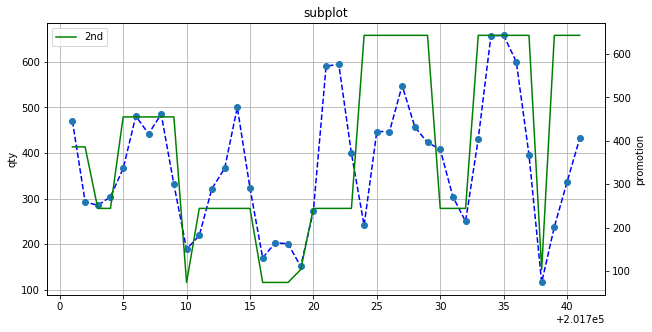

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

#팝업 창 활용하여 차트 시연
x= targetVisual.YEARWEEK
y= targetVisual.QTY
y2= targetVisual.PREDICT

feautresData2 = plt.figure(figsize=(10,5))

feautersDataAx1 = feautresData2.add_subplot(1,1,1) 

plt.plot(x,y, 'b--',lw=1.5)
plt.plot(x,y, 'o')
plt.grid(True)
plt.ylabel('qty')
plt.title('subplot')
feautersDataAx2 = feautersDataAx1.twinx() 
plt.plot(x,y2, 'g', lw=1.5, label='2nd')
plt.legend(loc=0)
plt.ylabel('promotion')